In this notebook, I explore how to fit distance sampling models for estimating the size of a closed population. Similar to the occupancy and closed capture-recapture notebooks, I use parameter-expanded data-augmentation (PX-DA) and the zero-inflated binomial model in this notebook.

The idea with distance sampling, also known as line-transect sampling, is that a surveyer traverses a transect, typically in a boat or a plane. As they survey, they note when they detect an individual, or a group, from the species of interest, and further note the distance from the transect to the animal. Further, they note the angle to the animal(s), such that they can calculate the perpendicular distance from the animal to the transect. We assume that probability of detecting an animal $p$ decreases monotonically as the distance from the transect grows, e.g., $p=\exp(-x^2/\sigma^2),$ where $x$ is the distance and $\sigma$ is a scale parameter to be estimated. These simple assumptions permit the estimation of the population size $N$ as well as density $D.$

Following @hooten2019, Chapter 24 and @royle2008, Chapter 7, I use the impala data from @burnham1980, who credits P. Hemingway with the dataset. In this dataset, 73 impalas were observed along a 60km transect. The distance values below are the perpendicular distances, in meters, from the transect. 

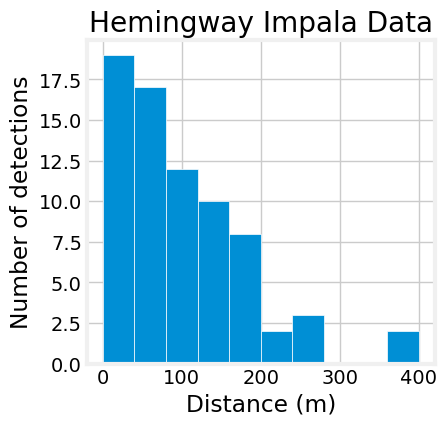

In [1]:
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# plotting defaults
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# hyper parameters
M = 500
U_X = 400
U_SIGMA = 400

# burnham impala dataset with distances in m
x_observed = np.array(
    [71.933980, 26.047227, 58.474341, 92.349221, 163.830409, 84.523652
    ,163.830409, 157.330098, 22.267696, 72.105330, 86.986979, 50.795047
    ,0.000000, 73.135370,  0.000000, 128.557522, 163.830409,  71.845104
    ,30.467336, 71.073909, 150.960702, 68.829172, 90.000000, 64.983827
    ,165.690874, 38.008322, 378.207430, 78.146226, 42.127052, 0.000000
    ,400.000000, 175.386612, 30.467336, 35.069692, 86.036465, 31.686029
    ,200.000000, 271.892336, 26.047227, 76.604444, 41.042417, 200.000000
    ,86.036465, 0.000000, 93.969262, 55.127471, 10.458689, 84.523652
    ,0.000000, 77.645714, 0.000000, 96.418141, 0.000000, 64.278761
    ,187.938524, 0.000000, 160.696902, 150.453756, 63.603607, 193.185165
    ,106.066017, 114.906666, 143.394109, 128.557522, 245.745613, 123.127252
    ,123.127252, 153.208889, 143.394109, 34.202014, 96.418141, 259.807621
    ,8.715574]
)

# plot the distances 
fig, ax = plt.subplots(figsize=(4,4))

ax.hist(x_observed, edgecolor='white')

ax.set_title('Hemingway Impala Data')
ax.set_ylabel('Number of detections')
ax.set_xlabel('Distance (m)')

plt.show()

Again, we treat this as a zero-inflated binomial model using PX-DA. The trick for doing so is to create a binary vector of length $M$, $y,$ that represents whether the individual was detected during the study. Then, combine the indicator with the distance vector $x$ to create a the full dataset $(x,y).$

In [2]:
n = len(x_observed)
unobserved_count = M - n
zeros = np.zeros(unobserved_count)

y = np.ones(n)
y_augmented = np.concatenate((y, zeros))

The issue is that $x$ is unobserved for the undetected individuals. To work around this, we put a uniform prior on the unobserved $x,$ i.e., $x \sim \text{Uniform}(0, U_x).$ With this "complete" $x,$ we can construct the detection function $p$ for the unobserved individuals.

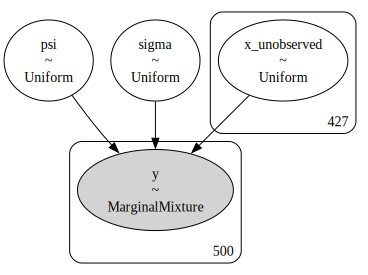

In [3]:
#| fig-cap: Visual representation of the distance sampling model. 
#| label: fig-dist

with pm.Model() as distance:
    
    psi = pm.Uniform('psi', 0, 1)
    sigma = pm.Uniform('sigma', 0, U_SIGMA)
    
    x_unobserved = pm.Uniform('x_unobserved', 0, U_X, shape=unobserved_count)
    x_complete = pt.concatenate((x_observed, x_unobserved))

    p = pm.math.exp(- x_complete ** 2 / sigma ** 2)

    pm.ZeroInflatedBinomial('y', p=p, psi=psi, n=1, observed=y_augmented)

pm.model_to_graphviz(distance)

In [4]:
with distance:
    distance_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, sigma, x_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


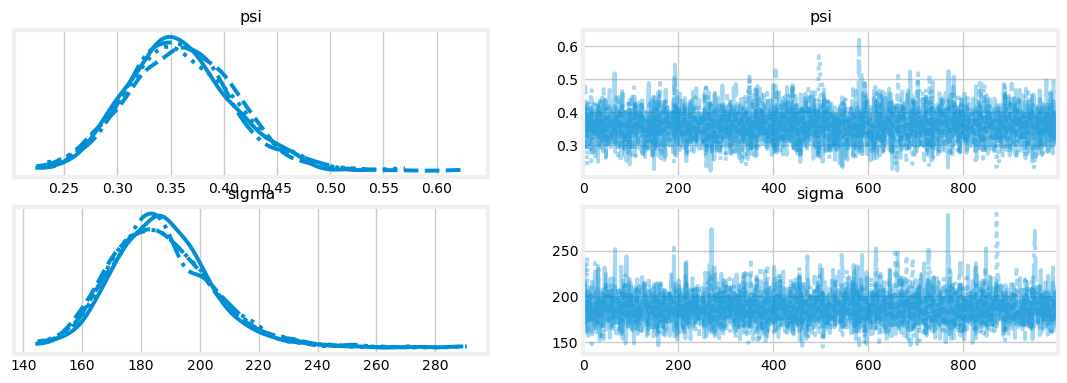

In [5]:
#| fig-cap: Traceplots for the distance sampling model.
#| label: fig-trace

az.plot_trace(
    distance_idata, 
    var_names=['psi', 'sigma']
);

This model samples slower than the models in the other notebooks, presumably because of the unobserved $x.$ As in the closed capture-recapture notebook, we will have to simulate the posterior for $N$ using the posterior distribution of $\psi$ and $M.$ 

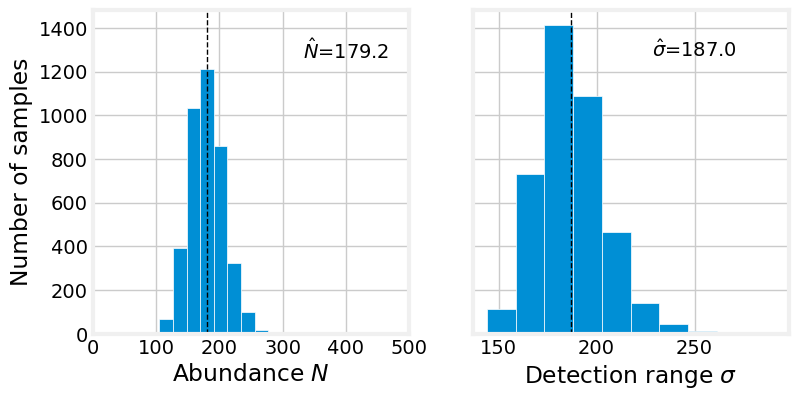

In [6]:
#| fig-cap: Posterior distributions for $N$ and $\sigma.$ Estimates from @royle2008 are shown with vertical lines.
#| label: fig-posteriors

RNG = np.random.default_rng()

# this does not make a copy of the posterior
post = distance_idata.posterior

# simulate draws of N using the posterior of psi 
N_samples = RNG.binomial(M, post.psi)
N_samples = N_samples.flatten()
N_hat = N_samples.mean()

sigma_samples = post.sigma.values.flatten()

# plot the results
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(8,4))

# histograms of the posteriors
ax0.hist(N_samples, edgecolor='white')
ax1.hist(sigma_samples, edgecolor='white')

# show the abundance dist in terms of M
ax0.set_xlim((0, M))

# axes labels 
ax0.set_xlabel('Abundance $N$')
ax0.set_ylabel('Number of samples')
ax1.set_xlabel('Detection range $\sigma$')

# add the point estimates
sigma_hat = sigma_samples.mean()
ax0.text(400, 1300, f'$\hat{{N}}$={N_hat:.1f}', ha='center', va='center')
ax1.text(250, 1300, f'$\hat{{\sigma}}$={sigma_hat:.1f}', ha='center', va='center')

# the results from royle and dorazio (2008) for comparison
N_hat_royle = 179.9
sigma_hat_royle = 187

ax0.axvline(N_hat_royle, linestyle='--', linewidth=1, color='black')
ax1.axvline(sigma_hat_royle, linestyle='--', linewidth=1, color='black')

plt.show()

The model shows a high level of agreement with @royle2008, Chapter 7, although note that they reported results in terms of 100m units. It is also possible to plot the posterior distribution of the detection function.

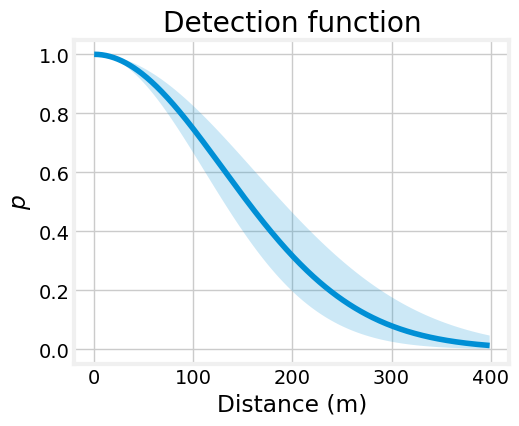

In [7]:
#| fig-cap: Posterior distribution for the detection function. The line represents the posterior mean while the shaded area is the 96% interval.
#| label: fig-func

xx = np.arange(400)
sigma_samps = post.sigma.values.flatten()

def det_func(x, s):
    return np.exp(- (x ** 2) / (s ** 2))

p_samps = np.array([det_func(xx, s) for s in sigma_samps])

p_mean = p_samps.mean(axis=0)
p_low = np.quantile(p_samps, 0.02, axis=0)
p_high = np.quantile(p_samps, 0.98, axis=0)

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(xx, p_mean, '-')
ax.fill_between(xx, p_low, p_high, alpha=0.2)

ax.set_title('Detection function')
ax.set_ylabel(r'$p$')
ax.set_xlabel(r'Distance (m)')

plt.show()